# Optimizing a spiking neural network

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/spiking-mnist.ipynb)

Almost all deep learning methods are based on [gradient
descent](https://en.wikipedia.org/wiki/Gradient_descent), which means that the network
being optimized needs to be differentiable.  Deep neural networks are usually built
using rectified linear or sigmoid neurons, as these are differentiable nonlinearities.
However, in neurmorphic modelling we often want to use spiking neurons, which are not
differentiable.  So the challenge is how to apply deep learning methods to spiking
neural networks.

A method for accomplishing this is presented in [Hunsberger and Eliasmith
(2016)](https://arxiv.org/abs/1611.05141).  The basic idea is to use a differentiable
approximation of the spiking neurons during the training process, and the actual spiking
neurons during inference.  NengoDL will perform these transformations automatically if
the user tries to optimize a model containing a spiking neuron model that has an
equivalent, differentiable rate-based implementation.  In this example we will use these
techniques to develop a network to classify handwritten digits
([MNIST](http://yann.lecun.com/exdb/mnist/)) in a spiking convolutional network.

In [18]:
!pip install nengo
!pip install nengo_dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

First we'll load the training data, the MNIST digits/labels.

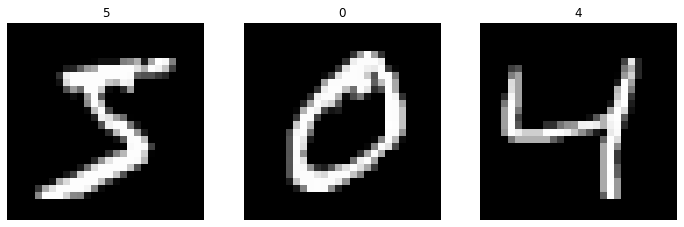

In [20]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))

Next we'll build a simple convolutional network. This architecture is chosen to be a
quick and easy solution for this task; other tasks would likely require a different
architecture, but the same general principles will apply.

We will use [TensorNodes](https://www.nengo.ai/nengo-dl/tensor-node.html) to construct
the network, as they allow us to directly insert TensorFlow code into Nengo. We could
use native Nengo objects instead, but in this example we'll use TensorNodes to make the
parallels with standard deep networks as clear as possible. To make things even easier,
we'll use ``nengo_dl.Layer``. This is a utility function for constructing TensorNodes
that mimics the Keras functional API.

`nengo_dl.Layer` is used to build a sequence of layers, where each layer takes the
output of the previous layer and applies some transformation to it. When working with
TensorFlow's Keras API, we can create Keras Layers and then simply pass those layer
objects to ``nengo_dl.Layer`` to encapsulate them in a ``TensorNode``.

Normally all signals in a Nengo model are (batched) vectors. However, certain layer
functions, such as convolutional layers, may expect a different shape for their inputs.
If the `shape_in` argument is specified when applying a `Layer` to some input, then the
inputs will automatically be reshaped to the given shape. Note that this shape does not
include the batch dimension on the first axis, as that will be set automatically by the
simulation.

`Layer` can also be passed a Nengo NeuronType, instead of a Tensor function. In this
case `Layer` will construct an Ensemble implementing the given neuron nonlinearity (the
rest of the arguments work the same).

Note that `Layer` is just a syntactic wrapper for constructing TensorNodes or Ensembles;
anything we build with a `Layer` we could instead construct directly using those
underlying components. `Layer` just simplifies the construction of this common
layer-based pattern.  The full documentation for this class can be found
[here](https://www.nengo.ai/nengo-dl/tensor-node.html).

In [21]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        x, shape_in=(26, 26, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(12, 12, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

Next we can construct a Simulator for that network.

In [22]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|###                   Building network (5%)                     | ETA: 0:00:03

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


Next we set up our training/testing data. We need to incorporate time into this data,
since Nengo models (and spiking neural networks in general) always run over time. When
training the model we'll be using a rate-based approximation, so we can run that for a
single timestep.  But when testing the model we'll be using the spiking neuron models,
so we need to run the model for multiple timesteps in order to collect the spike data
over time.

In [23]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In order to quantify the network's performance we'll use a classification accuracy
function (the percentage of test images classified correctly). We're using a custom
function here, because we only want to evaluate the output from the network on the final
timestep (as we are simulating the network over time).

In [24]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy before training: 0.08060000091791153


Now we are ready to train the network.  For training we'll use the standard categorical
cross entropy loss function, and the RMSprop optimizer.

In order to keep this example relatively quick we are going to download some pretrained
weights.  However, if you'd like to run the training yourself set `do_training=True`
below.

In [25]:
do_training = True
if do_training:
    # run training
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    sim.fit(train_images, {out_p: train_labels}, epochs=10)

    # save the parameters to file
    sim.save_params("./mnist_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1l5aivQljFoXzPP5JVccdFXbOYRv3BCJR",
        "mnist_params.npz",
    )

    # load parameters
    sim.load_params("./mnist_params")

Epoch 1/10
300/300 [==============================] - 206s 668ms/step - loss: 0.2871 - out_p_loss: 0.2871
Epoch 2/10
300/300 [==============================] - 198s 659ms/step - loss: 0.0743 - out_p_loss: 0.0743
Epoch 3/10
300/300 [==============================] - 203s 678ms/step - loss: 0.0521 - out_p_loss: 0.0521
Epoch 4/10
300/300 [==============================] - 201s 669ms/step - loss: 0.0421 - out_p_loss: 0.0421
Epoch 5/10
300/300 [==============================] - 198s 658ms/step - loss: 0.0328 - out_p_loss: 0.0328
Epoch 6/10
300/300 [==============================] - 211s 704ms/step - loss: 0.0276 - out_p_loss: 0.0276
Epoch 7/10
300/300 [==============================] - 203s 676ms/step - loss: 0.0226 - out_p_loss: 0.0226
Epoch 8/10
300/300 [==============================] - 202s 673ms/step - loss: 0.0175 - out_p_loss: 0.0175
Epoch 9/10
300/300 [==============================] - 202s 674ms/step - loss: 0.0146 - out_p_loss: 0.0146
Epoch 10/10
300/300 [=========================

Now we can check the classification accuracy again, with the trained parameters.

In [26]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy after training: 0.9873999953269958


We can see that the spiking neural network is achieving ~99% accuracy, which is what we
would expect for MNIST. `n_steps` could be increased to further improve performance,
since we would get a more accurate measure of each spiking neuron's output.

We can also plot some example outputs from the network, to see how it is performing over
time.

1/1 [==============================] - 16s 16s/step


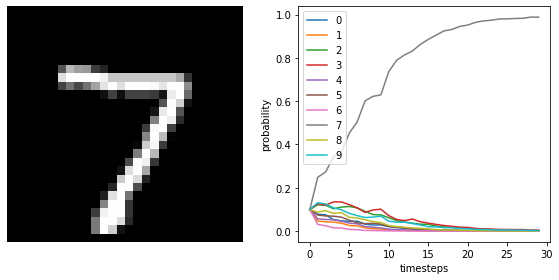

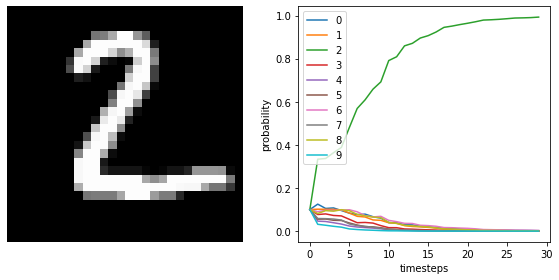

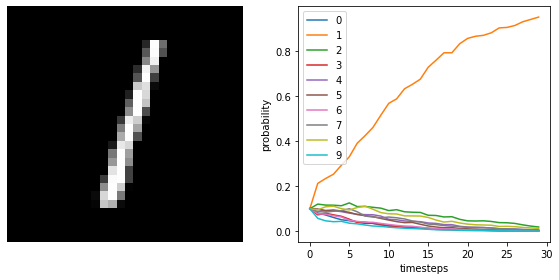

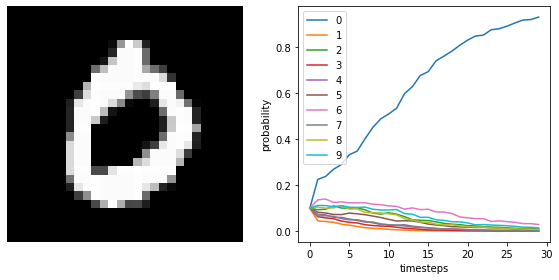

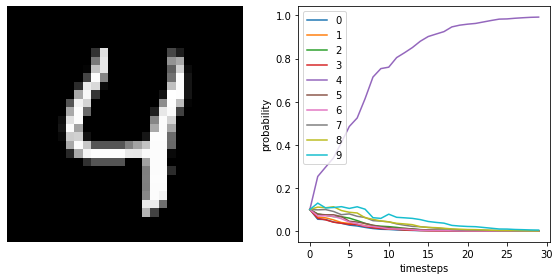

In [27]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [28]:
sim.close()